In [4]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from collections import defaultdict
import random, math
import numpy as np
%matplotlib inline


## The Agent
To get value V(s):
$$V(s) =   \max_a Q_i(s,a)$$
Moving average update:
$$Q(s_t,a_t)=(1-\alpha)*Q(s,a) + \alpha*(r + \gamma*V(s_t+1))$$
Policy:
$$\pi^*(s) = argmax_a Q_i(s,a)$$

In [3]:
class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):

        return self._qvalues[state][action]

    def set_qvalue(self,state,action,value):

        self._qvalues[state][action] = value

    def get_value(self, state):

        possible_actions = self.get_legal_actions(state)

        #If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        value_space = []
        for action in possible_actions:
            value_space.append(self.get_qvalue(state, action))
        value = np.max(value_space)
        return value

    def update(self, state, action, reward, next_state):

        #agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        new_q = (1-learning_rate) * self.get_qvalue(state, action)
        new_q += learning_rate * (reward + gamma * self.get_value(next_state))
        
        self.set_qvalue(state, action, new_q)

    
    def get_best_action(self, state):
 
        possible_actions = self.get_legal_actions(state)

        #If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        action_space = []
        for action in possible_actions:
            action_space.append(self.get_qvalue(state,action))
        best_action = possible_actions[np.argmax(action_space)]

        return best_action

    def get_action(self, state):

        # Pick Action
        possible_actions = self.get_legal_actions(state)
        action = None

        #If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        #agent parameters:
        epsilon = self.epsilon

        choice = np.random.choice(2, p = [epsilon,1-epsilon])
        if choice == 1: chosen_action = self.get_best_action(state)
        else: chosen_action = np.random.choice(possible_actions)
        
        return chosen_action

In [10]:
def play_and_train(env,agent,t_max=10**4):

    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        # get agent to pick action given state s.
        a = agent.get_action(s)
        
        next_s, r, done, _ = env.step(a)
        
        # train (update) agent for state s
        agent.update(s,a,r,next_s)
        
        s = next_s
        total_reward +=r
        if done: break
        
    return total_reward

## Binarizer
If the environment has a continuous set of possinle states, we have to group them into bins


In [9]:
from gym.core import ObservationWrapper
class Binarizer(ObservationWrapper):
    
    def _observation(self, state):    
        
        #state = <round state to some amount digits.>
        #hint: you can do that with round(x,n_digits)
        #you will need to pick a different n_digits for each dimension
        n_digits = [1,1,1,1]
        for i in range(len(n_digits)):
            state[i] = np.round(state[i],n_digits[i])
        
        return tuple(state)

In [13]:
env = Binarizer(gym.make("CartPole-v0"))
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
print("n_actions:", env.action_space.n)
n_actions = env.action_space.n

Observation space: Box(4,)
Action space: Discrete(2)
n_actions: 2


/home/otoshuki/anaconda/envs/tensorflow/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: <class '__main__.Binarizer'> doesn't implement 'observation' method. Maybe it implements deprecated '_observation' method.


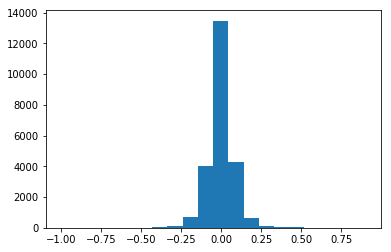

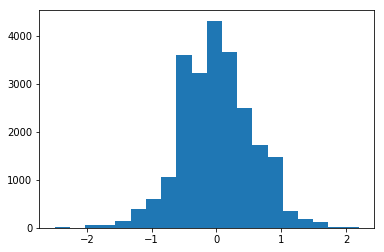

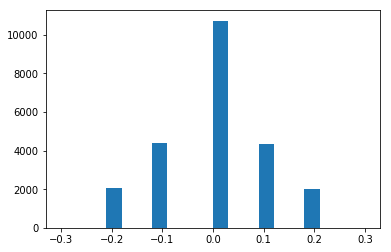

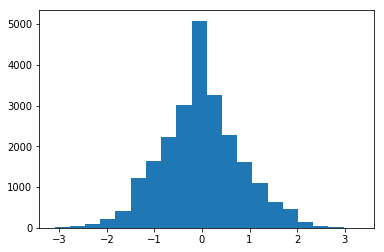

In [7]:
all_states = []
for _ in range(1000):
    all_states.append(env.reset())
    done = False
    while not done:
        s, r, done, _ = env.step(env.action_space.sample())
        all_states.append(s)
        if done: break
            
all_states = np.array(all_states)

for obs_i in range(env.observation_space.shape[0]):
    plt.hist(all_states[:,obs_i],bins=20)
    plt.show()

In [11]:
#Create agent
agent = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                       get_legal_actions = lambda s: range(n_actions))  

eps = 0.10149505898066467 mean reward = 38.16


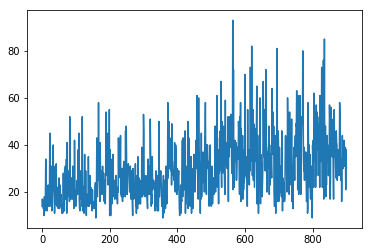

1531


In [14]:
#Training
from IPython.display import clear_output

rewards = []
env.reset()
for i in range(1000):
    rewards.append(play_and_train(env,agent))   
      
    agent.epsilon *= 0.999
    #OPTIONAL YOUR CODE: adjust epsilon
    if i %100 ==0:
        
        clear_output(True)
        print('eps =', agent.epsilon, 'mean reward =', np.mean(rewards[-100:]))
        plt.plot(rewards)
        plt.show()
        if np.mean(rewards[-10:]) > 100: break
print(len(agent._qvalues)) 

46.0


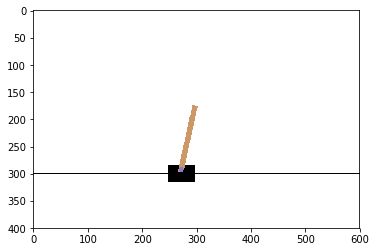

In [15]:
#Display final results
fig = plt.figure()
ax = fig.add_subplot(111)
total_reward = 0
s = env.reset()
#env.render()
for t in range(10000):
    #Action probabilities in current state
    a = agent.get_action(s)
    new_s, r, done, info = env.step(a)
    total_reward += r
    ax.clear()
    ax.imshow(env.render('rgb_array'))
    fig.canvas.draw()
    agent.update(s,a,r,new_s)
    #Set the new state
    s = new_s
    if done: break
print(total_reward)